##Language Model with RNN

Note from [cs224d](http://cs224d.stanford.edu/lecture_notes/LectureNotes4.pdf) of Stanford

References

LSTM ([org](http://web.eecs.utk.edu/~itamar/courses/ECE-692/Bobby_paper1.pdf), [reprint](http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf)
[Gated Feedback RNN](http://arxiv.org/pdf/1502.02367v3.pdf)

### bigram and tigram models

biagram ans trigram models are written as below

$$ p(w_2 | w_1 ) = \frac{\#(w_1, w_2)}{\#(w_1)}$$
$$ p(w_3 | w_1, w_2 ) = \frac{\#(w_1, w_2, w_3)}{\#(w_1, w_2)} $$

The count of each n-gram would be compared against the frequecy of each word. For instance, if the model takes bi-grams, the frequency of each bi-gram, calculated via combining a word with its previous word, would be divided by the frequency of the correspoinding uni-gram.


### RNN

RNN are capable of conditioning the model on $all$ previous words in the corpus.

With single layer, we write as below:

$$ h_t = Wf(h_{t-1}) + W^{(hx)} x_t $$
$$ \hat{y} = W^{(S)} f(h_t) $$

Here,

* $x_t$ : dx1 (d is feature dimention of word)
* $W^{(hx)}$ : $D_h$ x d ($D_h$ is the number of hidden unit)
* $W$ : $D_h$ x $D_h$
* $h_t$ : $D_h$ x 1
* $f(h_t)$ : $D_h$ x 1
* $W^{(s)}$ : $|v|$ x $D_h$ ($|v|$ is the voca size


The loss in RNN is often the cross entropy error.

$$ J^{(t)}(\theta) = - \sum_{j=1}^{|v|} y_{t_j} \times \log(\hat{y}_{t,j})$$

$$ J(\theta) = -\frac{1}{T} \sum_{t=1}^T \sum_{j=1}^{|v|} y_{t_j} \times \log(\hat{y}_{t,j})$$

### Vanishing Gradient & Gradient Explosion Problems

See below equation again,

$$ h_t = Wf(h_{t-1}) + W^{(hx)} x_t $$
$$ \hat{y} = W^{(S)} f(h_t) $$

To compute the RNN error, $\frac{\partial E}{\partial W}$, we sum the error at each time, $\frac{\partial E_t}{\partial W}$.

$$ \frac{\partial E}{\partial W} = \sum_{t=1}^T \frac{\partial E_t}{\partial W}$$

We wrote it again with chain rule,

$$\frac{\partial E_t}{\partial W} = \sum_{k=1}^t \frac{\partial E_t}{\partial y_t} \frac{\partial y_t}{\partial h_t} \frac{\partial h_t}{\partial h_k} \frac{\partial h_k}{\partial W}$$

In above equation, $\frac{\partial h_t}{\partial h_k}$ is a simply a chain rule differentiation over all hidden layers within the [k,t] time interval.

$$\frac{\partial h_t}{\partial h_k} = \prod_{j=k+1}^t \frac{\partial h_j}{\partial h_{j-1}} = \prod_{j=k+1}^t W^T \times \textrm{diag}[f'(h_{j-1})]$$


Below code is example of vanishing gradients from [cs224d]( http://cs224d.stanford.edu/notebooks/vanishing_grad_example.html)

In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

(-1, 1)

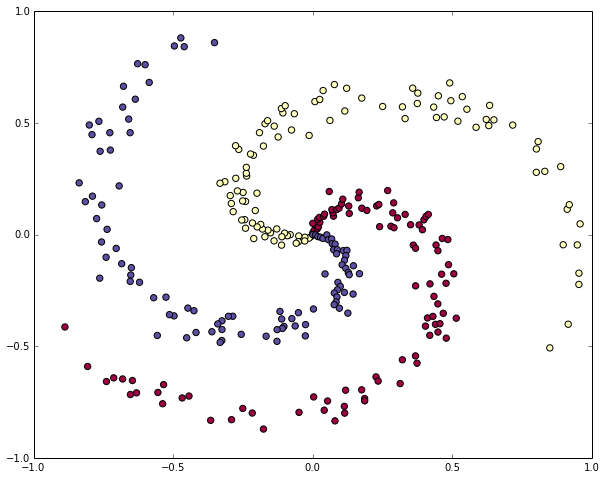

In [2]:
#generate random data -- not linearly separable 
np.random.seed(0)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D))
num_train_examples = X.shape[0]
y = np.zeros(N*K, dtype='uint8')
for j in xrange(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])

In [3]:
def sigmoid(x):
    x = 1/(1+np.exp(-x))
    return x

def sigmoid_grad(x):
    return (x)*(1-x)

def relu(x):
    return np.maximum(0,x)

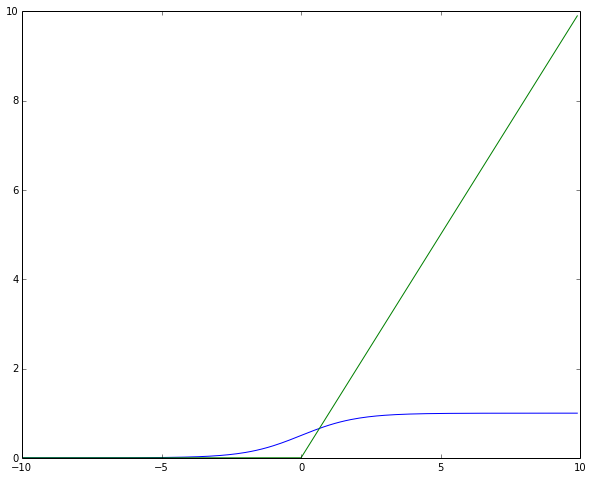

In [4]:
test_x = np.arange(-10.0,10.0, 0.1, dtype=float)
y_t = sigmoid(test_x)
plt.plot(test_x,y_t)

y_p = relu(test_x)
plt.plot(test_x, y_p)



In [5]:

def three_layer_net(NONLINEARITY,X,y, model, step_size, reg):
    #parameter initialization
    
    h= model['h']
    h2= model['h2']
    W1= model['W1']
    W2= model['W2']
    W3= model['W3']
    b1= model['b1']
    b2= model['b2']
    b3= model['b3']
    
    
    # some hyperparameters


    # gradient descent loop
    num_examples = X.shape[0]
    plot_array_1=[]
    plot_array_2=[]
    for i in xrange(50000):

        #FOWARD PROP

        if NONLINEARITY== 'RELU':
            hidden_layer = relu(np.dot(X, W1) + b1)
            hidden_layer2 = relu(np.dot(hidden_layer, W2) + b2)
            scores = np.dot(hidden_layer2, W3) + b3

        elif NONLINEARITY == 'SIGM':
            hidden_layer = sigmoid(np.dot(X, W1) + b1)
            hidden_layer2 = sigmoid(np.dot(hidden_layer, W2) + b2)
            scores = np.dot(hidden_layer2, W3) + b3

        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

        # compute the loss: average cross-entropy loss and regularization
        corect_logprobs = -np.log(probs[range(num_examples),y])
        data_loss = np.sum(corect_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2)+ 0.5*reg*np.sum(W3*W3)
        loss = data_loss + reg_loss
        if i % 1000 == 0:
            print "iteration %d: loss %f" % (i, loss)


        # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples),y] -= 1
        dscores /= num_examples

 
        # BACKPROP HERE
        dW3 = (hidden_layer2.T).dot(dscores)
        db3 = np.sum(dscores, axis=0, keepdims=True)


        if NONLINEARITY == 'RELU':

            #backprop ReLU nonlinearity here
            dhidden2 = np.dot(dscores, W3.T)
            dhidden2[hidden_layer2 <= 0] = 0
            dW2 =  np.dot( hidden_layer.T, dhidden2)
            plot_array_2.append(np.sum(np.abs(dW2))/np.sum(np.abs(dW2.shape)))
            db2 = np.sum(dhidden2, axis=0)
            dhidden = np.dot(dhidden2, W2.T)
            dhidden[hidden_layer <= 0] = 0
            
        elif NONLINEARITY == 'SIGM':

            #backprop sigmoid nonlinearity here
            dhidden2 = dscores.dot(W3.T)*sigmoid_grad(hidden_layer2)
            dW2 = (hidden_layer.T).dot(dhidden2)
            plot_array_2.append(np.sum(np.abs(dW2))/np.sum(np.abs(dW2.shape)))
            db2 = np.sum(dhidden2, axis=0)
            dhidden = dhidden2.dot(W2.T)*sigmoid_grad(hidden_layer)

        
        dW1 =  np.dot(X.T, dhidden)
        plot_array_1.append(np.sum(np.abs(dW1))/np.sum(np.abs(dW1.shape)))
        db1 = np.sum(dhidden, axis=0)

        # add regularization
        dW3+= reg * W3
        dW2 += reg * W2
        dW1 += reg * W1
        
        #option to return loss, grads -- uncomment next comment
        grads={}
        grads['W1']=dW1
        grads['W2']=dW2
        grads['W3']=dW3
        grads['b1']=db1
        grads['b2']=db2
        grads['b3']=db3
        #return loss, grads
        
        
        # update
        W1 += -step_size * dW1
        b1 += -step_size * db1
        W2 += -step_size * dW2
        b2 += -step_size * db2
        W3 += -step_size * dW3
        b3 += -step_size * db3
    # evaluate training set accuracy
    if NONLINEARITY == 'RELU':
        hidden_layer = relu(np.dot(X, W1) + b1)
        hidden_layer2 = relu(np.dot(hidden_layer, W2) + b2)
    elif NONLINEARITY == 'SIGM':
        hidden_layer = sigmoid(np.dot(X, W1) + b1)
        hidden_layer2 = sigmoid(np.dot(hidden_layer, W2) + b2)
    scores = np.dot(hidden_layer2, W3) + b3
    predicted_class = np.argmax(scores, axis=1)
    print 'training accuracy: %.2f' % (np.mean(predicted_class == y))  
    #return cost, grads
    return plot_array_1, plot_array_2, W1, W2, W3, b1, b2, b3

    

In [6]:
#Initialize toy model, train sigmoid net

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
h=50
h2=50
num_train_examples = X.shape[0]

model={}
model['h'] = h # size of hidden layer 1
model['h2']= h2# size of hidden layer 2
model['W1']= 0.1 * np.random.randn(D,h)
model['b1'] = np.zeros((1,h))
model['W2'] = 0.1 * np.random.randn(h,h2)
model['b2']= np.zeros((1,h2))
model['W3'] = 0.1 * np.random.randn(h2,K)
model['b3'] = np.zeros((1,K))

(sigm_array_1, sigm_array_2, s_W1, s_W2,s_W3, s_b1, s_b2,s_b3) = three_layer_net('SIGM', X,y,model, step_size=1e-1, reg=1e-3)

iteration 0: loss 1.156405
iteration 1000: loss 1.100737
iteration 2000: loss 0.999698
iteration 3000: loss 0.855495
iteration 4000: loss 0.819427
iteration 5000: loss 0.814825
iteration 6000: loss 0.810526
iteration 7000: loss 0.805943
iteration 8000: loss 0.800688
iteration 9000: loss 0.793976
iteration 10000: loss 0.783201
iteration 11000: loss 0.759909
iteration 12000: loss 0.719792
iteration 13000: loss 0.683194
iteration 14000: loss 0.655847
iteration 15000: loss 0.634996
iteration 16000: loss 0.618527
iteration 17000: loss 0.602246
iteration 18000: loss 0.579710
iteration 19000: loss 0.546264
iteration 20000: loss 0.512831
iteration 21000: loss 0.492403
iteration 22000: loss 0.481854
iteration 23000: loss 0.475923
iteration 24000: loss 0.472031
iteration 25000: loss 0.469086
iteration 26000: loss 0.466611
iteration 27000: loss 0.464386
iteration 28000: loss 0.462306
iteration 29000: loss 0.460319
iteration 30000: loss 0.458398
iteration 31000: loss 0.456528
iteration 32000: loss

(-1.8712034092398278, 1.8687965907601756)

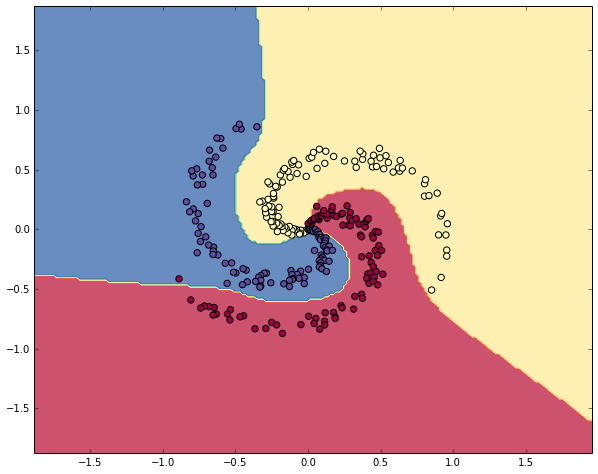

In [7]:
# plot the classifiers- SIGMOID
hh = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, hh),
                     np.arange(y_min, y_max, hh))
Z = np.dot(sigmoid(np.dot(sigmoid(np.dot(np.c_[xx.ravel(), yy.ravel()], s_W1) + s_b1), s_W2) + s_b2), s_W3) + s_b3
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

Train with ReLU

In [8]:
#Re-initialize model, train relu net
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
h=50
h2=50

model={}
model['h'] = h # size of hidden layer 1
model['h2']= h2# size of hidden layer 2
model['W1']= 0.1 * np.random.randn(D,h)
model['b1'] = np.zeros((1,h))
model['W2'] = 0.1 * np.random.randn(h,h2)
model['b2']= np.zeros((1,h2))
model['W3'] = 0.1 * np.random.randn(h2,K)
model['b3'] = np.zeros((1,K))

(relu_array_1, relu_array_2, r_W1, r_W2,r_W3, r_b1, r_b2,r_b3) = three_layer_net('RELU', X,y,model, step_size=1e-1, reg=1e-3)

iteration 0: loss 1.116188
iteration 1000: loss 0.275047
iteration 2000: loss 0.152297
iteration 3000: loss 0.136370
iteration 4000: loss 0.130853
iteration 5000: loss 0.127878
iteration 6000: loss 0.125951
iteration 7000: loss 0.124599
iteration 8000: loss 0.123502
iteration 9000: loss 0.122594
iteration 10000: loss 0.121833
iteration 11000: loss 0.121202
iteration 12000: loss 0.120650
iteration 13000: loss 0.120165
iteration 14000: loss 0.119734
iteration 15000: loss 0.119345
iteration 16000: loss 0.119000
iteration 17000: loss 0.118696
iteration 18000: loss 0.118423
iteration 19000: loss 0.118166
iteration 20000: loss 0.117932
iteration 21000: loss 0.117718
iteration 22000: loss 0.117521
iteration 23000: loss 0.117337
iteration 24000: loss 0.117168
iteration 25000: loss 0.117011
iteration 26000: loss 0.116863
iteration 27000: loss 0.116721
iteration 28000: loss 0.116574
iteration 29000: loss 0.116427
iteration 30000: loss 0.116293
iteration 31000: loss 0.116164
iteration 32000: loss

(-1.8712034092398278, 1.8687965907601756)

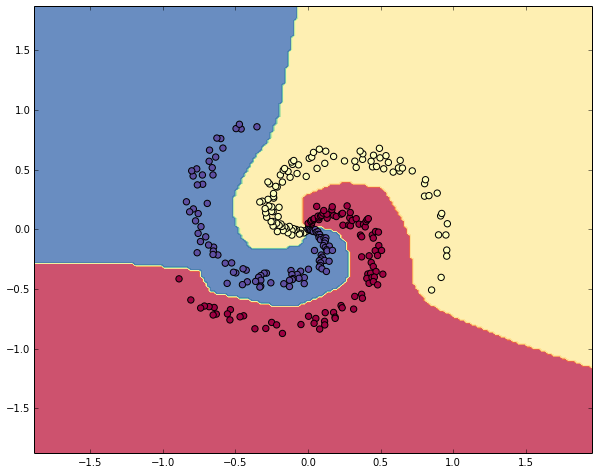

In [10]:
# plot the classifiers-- RELU
hh = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, hh),
                     np.arange(y_min, y_max, hh))
Z = np.dot(relu(np.dot(relu(np.dot(np.c_[xx.ravel(), yy.ravel()], r_W1) + r_b1), r_W2) + r_b2), r_W3) + r_b3
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

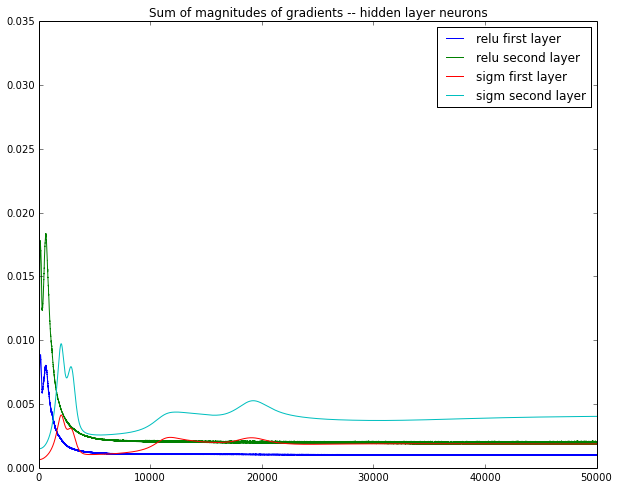

In [11]:
# Overlaying the two plots to compare
plt.plot(np.array(relu_array_1))
plt.plot(np.array(relu_array_2))
plt.plot(np.array(sigm_array_1))
plt.plot(np.array(sigm_array_2))
plt.title('Sum of magnitudes of gradients -- hidden layer neurons')
plt.legend(("relu first layer", "relu second layer","sigm first layer", "sigm second layer"))

## Vanishing Gradient Problem


During experimentation, once the gradient value grows extremely large, it causes an overflow (i.e. NaN) which is easily detectable at runtime; this issue is called the Gradient Explosion Problem. When the gradient value goes to zero, however, it can go undetected while dras- tically reducing the learning quality of the model for far-away words in the corpus; this issue is called the Vanishing Gradient Problem.

To solve the problem of vanishing gradients, we introduce two tech- niques. 

* The first technique is that instead of initializing W randomly, start off from an identify matrix initialization.

* The second technique is to use the Rectified Linear Units (ReLU) in- stead of the sigmoid function. The derivative for the ReLU is either 0 or 1. This way, gradients would flow through the neurons whose derivative is 1 without getting attenuated while propagating back through time-steps.

See above figure. We can use the sum of the magnitude of gradients for the weights between hidden layers as a cheap heuristic to measure speed of learning (you can also use the magnitude of gradients for each neuron in the hidden layer here). Intuitevely, when the magnitude of the gradients of the weight vectors or of each neuron are large, the net is learning faster. (NOTE: For our net, each hidden layer has the same number of neurons. If you want to play around with this, make sure to adjust the heuristic to account for the number of neurons in the layer).



## Long short-term memory

#### lstm

long short term memory

$$ i_t = \textrm{sigm}(\theta_{xi}x_t + \theta_{hi}h_{t-1} + b_i) $$
$$ f_t = \textrm{sigm}(\theta_{xf}x_t + \theta_{hf}h_{t-1} + b_f) $$
$$ o_t = \textrm{sigm}(\theta_{xo}x_t + \theta_{ho}h_{t-1} + b_o) $$
$$ g_t = \textrm{Tanh}(\theta_{xg}x_t + \theta_{hg}h_{t-1} + b_g) $$

$$ c_t = f_t \odot c_{t-1} + i_t \odot g_{t}$$
$$ h_t = o_t \odot \textrm{Tanh}(c_t)$$

In different notations,

$$ i^{(t)} = \sigma(W^{(i)}x^{(t)} + U^{(i)} h^{(t-1)}) $$
$$ f^{(t)} = \sigma(W^{(f)}x^{(t)} + U^{(f)} h^{(t-1)}) $$
$$ o^{(t)} = \sigma(W^{(o)}x^{(t)} + U^{(o)} h^{(t-1)}) $$
$$ \tilde{c}^{(t)} = \textrm{tanh}(W^{(c)}x^{(t)} + U^{(c)} h^{(t-1)}) $$
$$ c^{(t)} = f^{(t)} \circ \tilde{c}^{(t-1)} + i^{(t)} \circ \tilde{c}^{(t)} $$
$$ h^{(t)} = o^{(t)} \circ \textrm{tanh}(c^{(t)}) $$

Above equations are Input gate, Forget gate, Output/Exposure gate, new memory cell, and final memory cell respectively.


* New memory generation : This stage is an alogous to the new memory generation stage we saw in GRUs. We essentially use the input word $x^{(t)}$ and the past hidden state $h^{(t−1)}$ to generate a new memory $\tilde{c}^{(t)}$ which includes aspects of the new word $x^{(t)}$.

* Input Gate: We see that the new memory generation stage doesn’t check if the new word is even important before generating the new memory – this is exactly the input gate’s function. The input gate uses the input word and the past hidden state to determine whether or not the input is worth preserving and thus is used to gate the new memory. It thus produces $i^{(t)}$ as an indicator of this information.

* Forget Gate: This gate is similar to the input gate except that it does not make a determination of usefulness of the input word – instead it makes an assessment on whether the past memory cell is useful for the computation of the current memory cell. Thus, the forget gate looks at the input word and the past hidden state and produces $f^{(t)}$.

* Final memory generation: This stage first takes the advice of the forget gate $f^{(t)}$ and accordingly forgets the past memory $c^{(t−1)}$. Similarly, it takes the advice of the input gate $i^{(t)}$ and accordingly gates the new memory $\tilde{c}^{(t)}$. It then sums these two results to produce the final memory $c^{(t)}$.

* Output/Exposure Gate: This is a gate that does not explicitly exist in GRUs. It’s purpose is to separate the final memory from the hidden state. The final memory $c^{(t)}$ contains a lot of information that is not necessarily required to be saved in the hidden state. Hidden states are used in every single gate of an LSTM and thus, this gate makes the assessment regarding what parts of the memory $c^{(t)}$ needs to be exposed/present in the hidden state $h^{(t)}$. The signal it produces to indicate this is $o^{(t)}$ and this is used to gate the point- wise tanh of the memory.

#### gru

gated recurrent units

it is designed to have more persistent memory thereby making it easier for RNNs to capture long-term dependencies.

$$ z^{(t)} = \sigma(W^{(z)}x^{(t)} + U^{z}h^{(t-1)}) $$
$$ r^{(t)} = \sigma(W^{(r)}x^{(t)} + U^{r}h^{(t-1)}) $$
$$ \tilde{h}^{(t)} = \textrm{tanh}(r^{(t)}\circ Uh^{(t-1)} + Wx^{(t)}) $$
$$ h^{(t)} = (1-z^{(t)}) \circ \tilde{h}^{(t)} + z^{(t)} \cdot h^{(t-1)} $$


* New memory generation: A new memory $\tilde{h}^{(t)}$ is the consolidation of a new input word $x^{(t)}$ with the past hidden state $h^{(t−1)}$. Anthropomorphically, this stage is the one who knows the recipe of combining a newly observed word with the past hidden state $h^{(t−1)}$ to summarize this new word in light of the contextual past as the vector $\tilde{h}^{(t)}$.
* Reset Gate: The reset signal $r^{(t)}$ is responsible for determining how important $h^{(t−1)}$ is to the summarization $\tilde{h}^{(t)}$. The reset gate has the ability to completely diminish past hidden state if it finds that $h^{(t−1)}$ is irrelevant to the computation of the new memory.
* Update Gate: The update signal $z^{(t)}$ is responsible for determining how much of $h^{(t−1)}$ should be carried forward to the next state. For instance, if $z^{(t)} \approx 1$, then $h^{(t−1)}$ is almost entirely copied out to $h^{(t)}$. Conversely, if $z^{(t)} \approx 0$, then mostly the new memory $\tilde{h}^{(t)}$ is forwarded to the next hidden state.
* Hidden state: The hidden state $h^{(t)}$ is finally generated using the past hidden input $h^{(t−1)}$ and the new memory generated $\tilde{h}^{(t)}$ with the advice of the update gate.


<img src="figures/lstm.png" width=520><img src="figures/gru.png" width=520>



For GRU and LSTM, it is important to note that, we need to learn all different parameters! $W, U, W^{(r)}, U^{(r)}$ and etc.